<a href="https://colab.research.google.com/github/liangchow/soil-type-predictions/blob/main/soil_type_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivations

Interpreting soil type and properties from in-situ testing and measurement data is one of the daily tasks in my field. The most uniquitous, or perhaps the first to be standardized (i.e., ASTM),
is the Standard Penetration Test (SPT). The SPT test method retrieves soil samples and blowcounts in three consecutive 6 inches, of which the blowcounts of the first 6 inches are neglected as disturbed.
The sum of the second and last blowcounts is termed the "standard penetration resistance," or N-value, which has been extensively studied and empirically correlated to the stiffness or density of specific soil types.
In this context, soil type refers to coarse- and fine-grained soils, i.e., sand and clay. Five (5) or "1-2-3" blowcount soil, for instance,
is regarded as loose sand or medium stiff clay. However, unless the recovered soil sample is visually categorized or verified through additional testing, it is unknown whether the soil type is sand or clay.
In practice, blowcounts are not used for determining soil type.

This project explored the potential of identifying soil type based on sampling depths and blowcounts, contrary to general practice. The logic behind this is that if drilling mud is used to lessen soil disturbance or stress relief,
the blowcounts, assuming that the SPT hammer system is properly calibrated and operated at the accepted 60% or higher energy ratio, would correlate strongly to soil type.
Depth is an important factor as it represents the state of stress of the soil element. In addition, the neglected blowcounts from the first 6 inches of spoon could potentially serve as a valuable
indicator for different soil types.

#Set Up Worksheet and Import Libraries

In [1]:
# Clone Gitub repository to Colab
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git
!git clone https://github.com/liangchow/soil-type-predictions.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done

git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
fatal: destination path 'soil-type-predictions' already exists and is not an empty directory.


In [2]:
# Acess to soil-type-preidctions folder
%cd /content/soil-type-predictions

# Import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from utils_log import *
from utils_plot import *

/content/soil-type-predictions


In [3]:
# Google Colab GPU
# Check if GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


# Read Data
The dataset should contains the following. There is a total of 126 soil samples:
- ID: Boring ID
- Depth: Depth (ft) the sample was taken
- Sampler: MCS = Modified California Sampler or SPT = Standard Penetration Test
- N1: Known as "set". First set of blowcount counted over first 6 inches of sampler
- N2: The second set of blowcount from 6 to 12 inches of the sampler
- N3: The third set of blowcount from 12 to 18 inches of the sampler
- Soil: Generic soil types "clay" or "sand"
- USCS: USCS soil classification if there is data available

In [4]:
# Read soil data
file_path = "./field_data/soil.csv"
df = pd.read_csv(file_path)
df

,ID,Depth,Sampler,N1,N2,N3,Soil,UCSC
0,B-1,15.0,MCS,0.0,0.0,0.0,Clay,CL
1,B-1,20.0,MCS,0.0,0.0,0.0,Clay,CL
2,B-1,75.0,SPT,0.0,3.0,2.0,Clay,CH
3,B-1,100.0,SPT,24.0,19.0,20.0,Clay,CL
4,B-2,10.5,MCS,0.0,0.0,0.0,Clay,CL
...,...,...,...,...,...,...,...,...
121,AB-4,25.0,SPT,6.0,9.0,16.0,Sand,ML
122,AB-4,35.0,SPT,25.0,35.0,39.0,Sand,SC
123,AB-4,40.0,SPT,16.0,28.0,25.0,Sand,SC
124,AB-4,45.0,SPT,8.0,11.0,20.0,Sand,SC


# Data Pre-Processing
Before we visualize the data, we will have to convert the blowcount to equivalent "SPT" blowcount, then compute both SPT-N and take a difference between SPT-N and the "set". After we are done with that, we will create a "Class" column to categorize Sand as "1" and Clay as "0".
- By definition, SPT-N is the summation of SPT blowcount from 6 to 18 inches, i.e., N2 + N3 for the SPT sampler. Blowcount from the first 6 inches of sampler or "set" is considered as distrubed, and generally disregarded. We don't have to convert the blowcount obtain using the SPT sampler. However, for Modified California Sampler (MCS), a coverstion factor of 0.68 based on the area ratio is applied to the blowcount to get equivalent SPT-N.  
- After conversion to SPT blowcounts, we simply add the SPT blowcounts from the second and third sets to get "SPT-N". Then, we will add one more column to take a difference between SPT-N and SPT blowcount from the "set".  
- For simplicity, we will only group the soil type into two classes: Sand (y=1) and Clay (y=0). We will not use the USCS classifications in this exercise.

In [5]:
# Create a function to convert each blowcount (N1, N2, and N3) to equivalent SPT-N
def equiv_SPT_N(sampler, n_val):

  if sampler == "MCS":
    return 0.68*n_val
  else:
    return n_val

# Create a function to categorize Sand and Clay
def categorize_soil(soil):
  if soil == "Sand":
    return 1
  else:
    return 0

In [6]:
X = pd.DataFrame(df["Depth"])
X["Class"] = df["Soil"].apply(lambda x: categorize_soil(x))

# Apply functions to the dataframe().
X["SPT_N1"] = df.apply(lambda x: equiv_SPT_N(x["Sampler"], x["N1"]), axis=1)
X["SPT_N2"] = df.apply(lambda x: equiv_SPT_N(x["Sampler"], x["N2"]), axis=1)
X["SPT_N3"] = df.apply(lambda x: equiv_SPT_N(x["Sampler"], x["N3"]), axis=1)
X["SPT_N"] = X["SPT_N2"] + X["SPT_N3"]
X["SPT_N_diff"] = X["SPT_N"] - X["SPT_N1"]

X

,Depth,Class,SPT_N1,SPT_N2,SPT_N3,SPT_N,SPT_N_diff
0,15.0,0,0.0,0.0,0.0,0.0,0.0
1,20.0,0,0.0,0.0,0.0,0.0,0.0
2,75.0,0,0.0,3.0,2.0,5.0,5.0
3,100.0,0,24.0,19.0,20.0,39.0,15.0
4,10.5,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
121,25.0,1,6.0,9.0,16.0,25.0,19.0
122,35.0,1,25.0,35.0,39.0,74.0,49.0
123,40.0,1,16.0,28.0,25.0,53.0,37.0
124,45.0,1,8.0,11.0,20.0,31.0,23.0


# Data Visualization
Let's take a look at the data: The upper plot is for Clay (y=0) and the lower is for Sand (y=1). When SPT-N is plotted against depths, we see two clusters of data. Clay data points tend to skew toward lower blowcount, while Sand data points spread across the range from 0 to 200. This is great because we can clearly draw a boundary line in between these two clusters.

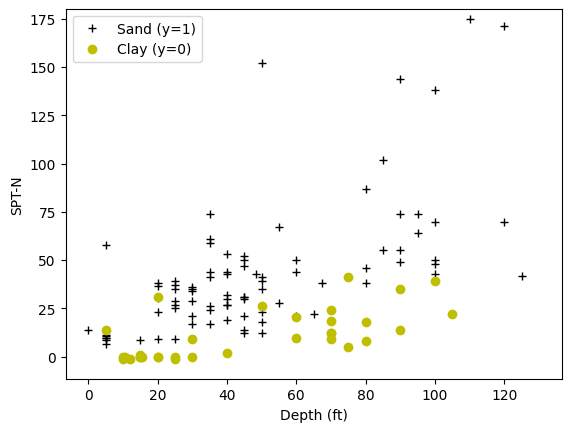

In [8]:
# Plotting two classes: Clay and Sand

Xi = X[["Depth", "SPT_N", "Class"]]

# Define class and features
class_1 = "Sand (y=1)" # pos
class_0 = "Clay (y=0)" # neg

positive = Xi.loc[Xi["Class"] == 1]
negative = Xi.loc[Xi["Class"] == 0]

# Plot data
plt.plot(positive["Depth"], positive["SPT_N"], 'k+', label=class_1)
plt.plot(negative["Depth"], negative["SPT_N"], 'yo', label=class_0)

plt.xlabel("Depth (ft)")
plt.ylabel("SPT-N")
plt.ylim(top=180)
plt.legend(loc="upper left")
plt.show()

# Data Processing
In this step, we prepare the training data by normalizaing and mapping features (i.e., SPT_N1, SPT_N2, etc.) to a higher order. The example below uses a degree of 2. After feature mapping to second degree order, the number of features increased from 6 to 27. All these 27 features are used in training the model.

In [9]:
# Separate data into X_train and y_train
y_train = X["Class"]
X_train = X.drop("Class", axis=1)
X_train.head()

,Depth,SPT_N1,SPT_N2,SPT_N3,SPT_N,SPT_N_diff
0,15.0,0.0,0.0,0.0,0.0,0.0
1,20.0,0.0,0.0,0.0,0.0,0.0
2,75.0,0.0,3.0,2.0,5.0,5.0
3,100.0,24.0,19.0,20.0,39.0,15.0
4,10.5,0.0,0.0,0.0,0.0,0.0


In [10]:
# Normalize data using z-score
Xn = norm_zscore(X_train)

for j in range(X_train.shape[1]):
    print(f"{X_train.columns[j]} - Max, Min pre-normalization: {np.max(X_train.iloc[:,j]):0.2f}, {np.min(X_train.iloc[:,j]):0.2f}")
    print(f"{X_train.columns[j]} - Max, Min post-normalization: {np.max(Xn[:,j]):0.2f}, {np.min(Xn[:,j]):0.2f} \n")

Depth - Max, Min pre-normalization: 130.00, 0.00
Depth - Max, Min post-normalization: 2.44, -1.56 

SPT_N1 - Max, Min pre-normalization: 100.00, -0.68
SPT_N1 - Max, Min post-normalization: 5.07, -0.77 

SPT_N2 - Max, Min pre-normalization: 100.00, -0.68
SPT_N2 - Max, Min post-normalization: 4.73, -0.96 

SPT_N3 - Max, Min pre-normalization: 168.00, -0.68
SPT_N3 - Max, Min post-normalization: 4.53, -0.80 

SPT_N - Max, Min pre-normalization: 200.00, -1.36
SPT_N - Max, Min post-normalization: 3.51, -0.93 

SPT_N_diff - Max, Min pre-normalization: 178.00, -0.68
SPT_N_diff - Max, Min post-normalization: 4.55, -0.88 



In [11]:
# Feature mapping
X_train = Xn

# Map features to higher order
print("Original shape of data:", X_train.shape)

degree = 2 # Order
X_mapped =  map_feature(X_train, degree)
print("Shape after feature mapping:", X_mapped.shape)

Original shape of data: (126, 6)
Shape after feature mapping: (126, 27)


In [12]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", X_mapped[0])

X_train[0]: [-1.10042641 -0.73011994 -0.91818182 -0.77721561 -0.90118616 -0.85945621]
mapped X_train[0]: [-1.10042641 -0.73011994 -0.91818182 -0.77721561 -0.90118616 -0.85945621
  1.21093828  0.80344326  1.01039152  0.85526859  0.99168905  0.94576831
  0.53307512  0.67038285  0.56746061  0.65797398  0.62750611  0.84305785
  0.71362524  0.82745274  0.78913707  0.60406411  0.70041595  0.66798279
  0.81213649  0.77453004  0.73866498]


# Learning using Gradient Descent

In [13]:
# Initialize fitting parameters
initial_w = np.zeros(X_mapped.shape[1])
initial_b = 0

# Set regularization parameter lambda_ (you can try varying this)
lambda_ = 0.1

# Some gradient descent settings
iterations = 10000
alpha = 0.05

w, b, J_history, _ = gradient_descent(X_mapped, y_train, initial_w, initial_b,
                                   compute_cost_logistic_reg, compute_gradient_logistic_reg,
                                   alpha, iterations, lambda_)

Iteration    0: Cost    0.640   
Iteration 1000: Cost    0.274   
Iteration 2000: Cost    0.251   
Iteration 3000: Cost    0.243   
Iteration 4000: Cost    0.239   
Iteration 5000: Cost    0.237   
Iteration 6000: Cost    0.235   
Iteration 7000: Cost    0.234   
Iteration 8000: Cost    0.233   
Iteration 9000: Cost    0.232   
Iteration 9999: Cost    0.232   


In [14]:
# Print results
print("Optimized weights:", w)
print("Optimized bias:", b)

# Compute accuracy on our training set
p = predict(X_mapped, w, b)

print(f"Train Accuracy: {np.mean(p == y_train)*100:0.3f}")

Optimized weights: [-1.5771187   2.89494422  2.58600963  0.54612462  1.39116345  0.40106989
 -0.58004334 -0.6507563   1.31243942 -0.2663822   0.3265531   0.79070764
 -0.38513201 -0.15553513 -0.36318455 -0.31429982 -0.23141762  0.19828492
 -0.4558987  -0.2408562  -0.25043883  0.03913395 -0.1507146  -0.01750318
 -0.19928131 -0.1100207  -0.03042552]
Optimized bias: 4.387141075977776
Train Accuracy: 90.476


In [19]:
X_mapped.shape[1]

27

# Plot Decision Boundary
Note that since we trained on the normalized training set, the trained weights and biases are only applicable to the normalized data.

ValueError: shapes (2500,5) and (27,) not aligned: 5 (dim 1) != 27 (dim 0)

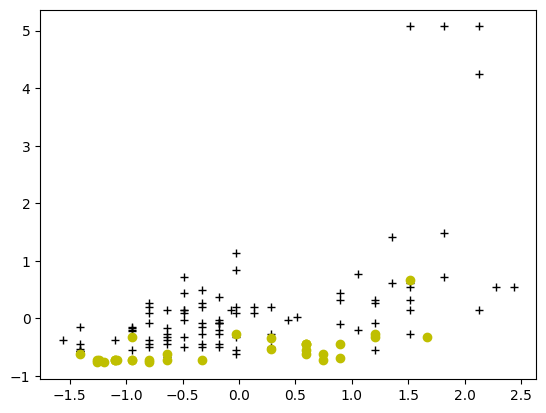

In [22]:
# Re-plot data (normalized data)
plot_data(X_mapped, class_0, class_1)

# Plot decision boundary
plot_decision_boundary(w, b, X_mapped, y_train, degree)

X = X_mapped
if X.shape[1] <= 2:
  plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
  plot_y = (-1. / w[1]) * (w[0] * plot_x + b)

  plt.plot(plot_x, plot_y, c="b")

else:
  pad = 0.1 # padding for xlim, ylim
  xx, yy = np.meshgrid(np.linspace(min(X[:,0]) -pad, max(X[:,0]) +pad, 50), np.linspace(min(X[:,1]) -pad, max(X[:,1]) +pad, 50))
  x_in = np.c_[xx.ravel(), yy.ravel()]
  Z = sigmoid(np.dot(map_feature(x_in, degree), w) + b)

  Z = Z.reshape(xx.shape)

  # Plot z = 0.5
  plt.contour(xx,yy,Z, levels = [0.5], colors="g")

# plot_decision_boundary(w[2], b, X_mapped[0:2,:], y_train, degree)

plt.ylabel("Depth")
plt.xlabel("SPT-N")
plt.lgeng(loc="upper right")
plt.show()